# Testing one target

Saved residuals to Hamal_QWP_V_0.05_residuals_matrix_noise_1_tint_60_sub_tint_1_readout_noise_0_additive_QWP_V_optimal_angles_1.npy
Saved residuals to Hamal_QWP_V_0.05_residuals_matrix_noise_2_tint_60_sub_tint_1_readout_noise_0_additive_QWP_V_optimal_angles_1.npy
Saved residuals to Hamal_QWP_V_0.05_residuals_matrix_noise_3_tint_60_sub_tint_1_readout_noise_0_additive_QWP_V_optimal_angles_1.npy
Saved residuals to Hamal_QWP_V_0.05_residuals_matrix_noise_4_tint_60_sub_tint_1_readout_noise_0_additive_QWP_V_optimal_angles_1.npy
Saved residuals to Hamal_QWP_V_0.05_residuals_matrix_noise_5_tint_60_sub_tint_1_readout_noise_0_additive_QWP_V_optimal_angles_1.npy


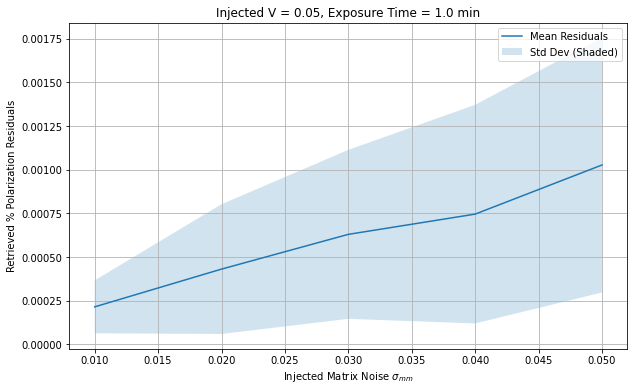

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../python/')
import angles
import instrument_mm

# Define observer parameters
observer_latitude = 20.0  # Latitude of Mauna Kea in degrees
observer_longitude = -155.5  # Longitude of Mauna Kea in degrees

# Define target parameters
targets = [
    {"name": "Hamal", "ra": 31.791, "dec": 23.462},  # Hamal (Alpha Arietis)
    # {"name": "Mirfak", "ra": 51.079, "dec": 49.861},  # Mirfak (Alpha Persei)
    # {"name": "Polaris", "ra": 37.954, "dec": 89.264},  # Polaris (Alpha Ursae Minoris)
]

# Observation date and time
observation_date = "2460614.91667"  # JD for 10/31/2024
observation_time = "10:00:00"   # UT time to get peak at midnight HST
matrix_noise_type = "additive"
filename_tag = "QWP_V_optimal_angles_1"

# Fixed integration time and sub-integration time
t_int = 1 * 60  # 1 minute in seconds
sub_tint = 1  # 0.5 seconds
num_samples = 100

# Injected polarization
Q_injected = 0  # Injected Stokes Q
U_injected = 0  # Injected Stokes U
V_injected = 0.05
noise_percentage = 0  # Intensity noise
include_V = True

# HWP properties
delta_HWP = 0.25
# HWP_angs = np.array([0, 22.5, 45, 67.5])
# HWP_angs = np.array([0, 45, 90, 135])
# HWP_angs = np.array([-45, 45, -135, 135])
HWP_angs = np.array([-51.69, 51.69, -15.12, 15.12])

# Matrix noise range
matrix_noise_range = np.arange(1, 6)  # From 1% to 5%
num_trials = 50  # Number of trials per noise level

# Loop over each target
for target in targets:
    mean_residuals = []
    std_residuals = []

    # Loop over matrix noise levels
    for matrix_noise in matrix_noise_range:
        residuals = []

        # Perform multiple trials for each noise level
        for trial in range(num_trials):
            S_in_retrieved = instrument_mm.calculate_input_Q_U_observing_sequence_matrix_inversion(
                ra=target["ra"], 
                dec=target["dec"], 
                observer_latitude=observer_latitude, 
                observer_longitude=observer_longitude, 
                jd_str=observation_date, 
                ut_start=observation_time, 
                t_int=t_int, 
                Q=Q_injected, 
                U=U_injected, 
                V=V_injected,
                delta_HWP=delta_HWP,
                HWP_angs = HWP_angs,
                noise_percentage=noise_percentage,
                include_V=include_V,
                sub_tint=sub_tint,  # Sub-integration time in seconds
                TMT_matrix_noise=matrix_noise,
                NFIRAOS_matrix_noise=matrix_noise,
                MODHIS_matrix_noise=matrix_noise,
                observable="intensities",  # Or "single_difference" if needed
                sampled_steps = num_samples,
                matrix_noise_type = matrix_noise_type
            )
            
            # Calculate retrieved polarization
            Q_retrieved, U_retrieved = S_in_retrieved[1], S_in_retrieved[2]
            retrieved_polarization = np.sqrt(Q_retrieved**2 + U_retrieved**2)
            injected_polarization = np.sqrt(Q_injected**2 + U_injected**2)
            
            # Calculate absolute residuals
            residual = np.abs(injected_polarization - retrieved_polarization)
            residuals.append(residual)

        # Compute mean and standard deviation of residuals for this noise level
        mean_residuals.append(np.mean(residuals))
        std_residuals.append(np.std(residuals))

        # Save the residuals as a .npy file
        filename = f"{target['name']}_QWP_V_{V_injected}_residuals_matrix_noise_{matrix_noise}_tint_{t_int}_sub_tint_{sub_tint}_readout_noise_{noise_percentage}_{matrix_noise_type}_{filename_tag}.npy"
        np.save(filename, np.array(residuals))
        print(f"Saved residuals to {filename}")

    # Plot the results for this target
    plt.figure(figsize=(10, 6))
    mean_residuals = np.array(mean_residuals)
    std_residuals = np.array(std_residuals)
    plt.plot(matrix_noise_range / 100, mean_residuals, label=f"Mean Residuals")
    plt.fill_between(matrix_noise_range / 100, mean_residuals - std_residuals, mean_residuals + std_residuals, alpha=0.2, label="Std Dev (Shaded)")
    plt.xlabel(r"Injected Matrix Noise $\sigma_{mm}$")
    plt.ylabel("Retrieved % Polarization Residuals")
    plt.title(
        f"Injected V = {V_injected}, Exposure Time = {t_int / 60:.1f} min"
    )
    plt.grid(True)
    plt.legend()
    plt.show()


# Regenerating Plots

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Define target parameters
targets = [
    {"name": "Hamal", "ra": 31.791, "dec": 23.462},  # Hamal (Alpha Arietis)
]

# Matrix noise range and other constants
matrix_noise_range = np.arange(1, 6)  # From 1% to 5%
t_int = 1 * 60  # Integration time in seconds
sub_tint = 1  # Sub-integration time in seconds
V_injected = 0.01  # Injected Stokes V
noise_percentage = 0  # Intensity noise
matrix_noise_type = "additive"

# Loop over each target
for target in targets:
    mean_residuals = []
    std_residuals = []

    # Read saved residuals for each matrix noise level
    for matrix_noise in matrix_noise_range:
        filename = f"{target['name']}_QWP_V_{V_injected}_residuals_matrix_noise_{matrix_noise}_tint_{t_int}_sub_tint_{sub_tint}_readout_noise_{noise_percentage}_{matrix_noise_type}_{filename_tag}.npy"
        residuals = np.load(filename)
        mean_residuals.append(np.mean(residuals))
        std_residuals.append(np.std(residuals))

    # Plot the results for this target
    plt.figure(figsize=(10, 6))
    mean_residuals = np.array(mean_residuals)
    std_residuals = np.array(std_residuals)
    plt.plot(matrix_noise_range / 100, mean_residuals, '-o', label=f"Mean Residuals")
    plt.fill_between(matrix_noise_range / 100, mean_residuals - std_residuals, mean_residuals + std_residuals, alpha=0.2, label="Std Dev (Shaded)")
    plt.xlabel(r"Injected Matrix Noise $\sigma_{mm}$")
    plt.ylabel("Retrieved Stokes V Residuals")
    plt.title(
        f"{target['name']} - Injected V = {V_injected}, Exposure Time = {t_int / 60:.1f} min"
    )
    plt.grid(True)
    plt.legend()
    plt.xlim(0.045, 0.05)
    plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'Hamal_QWP_V_0.01_residuals_matrix_noise_1_tint_60_sub_tint_1_readout_noise_0_additive_QWP_V_optimal_angles_1.npy'

# Printing .npy files

In [ ]:
Hamal_QWP_V_0.03_residuals_matrix_noise_5_tint_60_sub_tint_1_readout_noise_0_additive_HWP_regular_modulation.npy